<a href="https://colab.research.google.com/github/JacobTumak/cap-comp215/blob/main/Prisoners_Dilemma_Comp_215_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**The Prisoners Dilemma**
####Author: Jacob Tumak

**What is the prisoners dilemma?**

The Prisoner's Dilemma is a classic problem in game theory that was originally framed by Merrill Flood and Melvin Dresher in 1950 as a hypothetical scenario in which two individuals are arrested and charged with a crime, but there is not enough evidence to convict either one of them.

The scenario can be illustrated as follows: Two suspects, A and B, are arrested for a crime and held in separate cells. The police do not have enough evidence to convict either suspect, so they offer each one a deal: D the other suspect and you will 

* If both suspects remain silent, they both receive a 1 year sentence.
* If one suspect confesses and the other remains silent, the confessor goes free while the other receives a 3 year sentence.
* If both suspects confess, they both receive a 2 year sentence.

The significance of the Prisoner's Dilemma is that it highlights the tension between individual rationality and collective welfare. Both suspects would be better off if they cooperated and remained silent, but the incentive to defect and D the other is strong because it offers a better outcome if the other cooperates.

The Prisoner's Dilemma has been used to study a wide range of social phenomena, from international relations to corporate strategy to environmental policy. It has also been used to explore the evolution of cooperation and altruism in biological systems.

**About This NoteBook:**

My goal for this notebook is to experiment with different strategies for prisoners and graph their effectiveness by measuring the amount of time it was sentenced for.

More-so I want to create a program that will "learn" how to get the lowest possible sentence. 

I'll do this by creating a Prisoner object that is able to learn based on previous outcomes and use probability to reflect slight unpredictability which I feel more accurately models human behaviour, and creates more interesting outcomes.

A simulation function or class will be used to run this experiment hundreds or thousands of times to allow succesful strategies to emerge from the others.

Then we can analyze the most succesful strategies to see what makes them good.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# let's assign values to variables that indicate the action of a prisoner.
# These values aren't completely arbitrary. I'm using a 1 and a 0 because that
# allows me to use them as a boolean value.
D = 0
C = 1

In [2]:
def merge(list1, list2):
  return [(list1[i], list2[i]) for i in range(0, len(list1))]

In [3]:
class Prisoner:
  def __init__(self, action_args=None, strategy=None, first_move=None):
    '''
    The strategy function must take a prisoner object as input and return either:
    • 0 (Betray)
    • 1 (Cooperate)
    '''
    self.strategy = strategy
    self.sentences = list()
    self.memory = list()
    self.action_args = action_args
    self.first_move = first_move or np.random.choice([0, 1])
    

  def get_avg_sentence(self):
    self.avg_sentence = sum(self.sentences)/len(self.sentences)


  def memorize(self, sentence):
    if sum(sentence) == 3:
      other_action = abs(self.action - 1)
    else:
      other_action = self.action
    self.last_action = (self.action, other_action)
    self.memory.append(self.last_action)
    self.last_sentence = sentence[self.action]
    self.sentences.append(self.last_sentence)
    self.get_avg_sentence()


  def erase_memory(self):
    self.memory = []


  def new_action(self):
    '''
    Takes prisoner object and strategy function as input and returns a 1 or 0.
    '''
    self.action = self.strategy(self, self.action_args)

Now that we have the structure for our prisoner objects and a function for getting the sentences for each prisoner. I'll create a prisoner that can use a couple different strategies to make testing it easier later.

In [131]:
class SmartPrisoner(Prisoner):
  keys = [(C, C),
          (C, D),
          (D, C),
          (D, D),]


  def __init__(self, rand_strategy=False, init_map=None, start_move=-1):
    super().__init__(start_move)
    self.last_action = None
    if init_map:
      self.map_keys(init_map)
      self.strategy = self.learn
    elif rand_strategy:
      self.map_keys(-1)
      self.strategy = self.strat_pass
    else:
      self.map_keys(start_move)
      self.strategy = self.learn
    self.time_served = None


  def get_prob(self):
    return sum(self.results[self.last_action])/len(self.results[self.last_action])

  def strat_pass(self):
    pass


  def learn(self):
    self.results[self.last_action].append([D, C][self.last_action[1]])

    self.p = self.get_prob()
    self.mapping[self.last_action] = np.random.choice([D, C], p=[1-self.p, self.p])


  def map_keys(self, start_move):
    if type(start_move)==dict:
      self.mapping = start_move
    elif start_move < 0:
      self.mapping = {key: np.random.choice([D, C]) for key in self.keys}
    else:
      self.mapping = {key: start_move for key in self.keys}
    self.results = {key: [1] for key in self.keys}


  def memorize(self, sentence):
    super().memorize(sentence)
    self.time_served = sum(self.sentences)
    self.strategy()

  def new_action(self):
    if self.last_action:
      self.action = self.mapping[self.last_action]
    else:
      self.action = self.first_move

Now we have a SmartPrisoner class which will (hopefully) "learn" to adapt its mapping to give it the best chance at a low sentence.

In [124]:
class Simulate:

  def __init__(self, init_map=None, n_trials=100):
    self.pris_a = SmartPrisoner(init_map=init_map)
    self.pris_b = SmartPrisoner(rand_strategy=True)
    self.n = n_trials
    self.sentences = []

  
  def sentence_prisoners(self):
    '''
    Takes two prisoner objects and returns a tuple with integers mapped to the
    prisoners actions array space.
    '''
    self.pris_a.new_action()
    self.pris_b.new_action()

    sentences = [(2,2), (0, 3), (1, 1)]
    sentence = sentences[self.pris_a.action + self.pris_b.action] # the sum of both actions is equal to the array space for the sentence
    self.pris_a.memorize(sentence)
    self.pris_b.memorize(sentence)
    return sentence

  def simulate(self):
    sentences = []
    for trial in range(self.n):
      sentence = self.sentence_prisoners()
    self.sentences.extend(merge(self.pris_a.sentences, self.pris_b.sentences))

  def draw(self):
    plt.plot(range(len(self.sentences)), self.pris_a.sentences, label='prisoner a')
    plt.plot(range(len(self.sentences)), self.pris_b.sentences, label='prisoner b')
    plt.ylabel("years sentenced")
    plt.xlabel("trial number")
    plt.legend()

  def get_better_map(self):
    better_map = [(self.pris_a.mapping, self.pris_a.avg_sentence), (self.pris_b.mapping, self.pris_b.avg_sentence)][self.pris_a.time_served > self.pris_b.time_served]
    return better_map

({(1, 1): 1, (1, 0): 0, (0, 1): 0, (0, 0): 1}, 1.39)

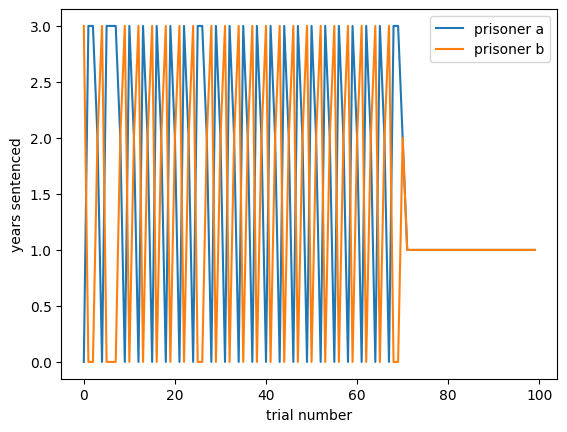

In [225]:
sim_test = Simulate()
sim_test.simulate()
sim_test.draw()
sim_test.get_better_map()

Now that we have a simulate method. We can create a series of simulations where the more successful mapping is passed to the next simulation. We can run 100 simulations 100 times and measure to see if specific mappings stand out in the number of times they were succesful. 

In [208]:
def convert_maps(tuple_list):
  "Converts a list of 2-tuples to dict. Helper function for map averaging."
  maps = {get_key(map[0]):0 for map in tuple_list if len(map[0].values())==4}
  for map in maps:
    maps[map] = [avg[1] for avg in tuple_list if get_key(avg[0]) == map]
    maps[map] = {"occurences":len(maps[map]), "average sentence": sum(maps[map])/len(maps[map])}
  return maps

def get_key(input_dict):
  key = [str(val) for val in input_dict.values()]
  key = int("".join(key))
  return key

The functions above are helper functions to show the combinations and their corresponding metrics more easily.

In [212]:
map = None
maps = []
n = 1000
sim = Simulate()
sim.simulate()
map = sim.get_better_map()
for i in range(n):
  sim = Simulate(map[0])
  sim.simulate()
  map = sim.get_better_map()
  maps.append(map)
convert_maps(maps)

{1010: {'occurences': 488, 'average sentence': 1.315225409836064},
 1011: {'occurences': 244, 'average sentence': 1.293770491803278},
 11: {'occurences': 3, 'average sentence': 1.4033333333333333},
 0: {'occurences': 30, 'average sentence': 1.619666666666667},
 1000: {'occurences': 52, 'average sentence': 1.419423076923077},
 1100: {'occurences': 12, 'average sentence': 1.7975},
 10: {'occurences': 46, 'average sentence': 1.431521739130435},
 1001: {'occurences': 10, 'average sentence': 1.4649999999999999},
 1111: {'occurences': 59, 'average sentence': 1.2381355932203388},
 1110: {'occurences': 33, 'average sentence': 1.208484848484848},
 1101: {'occurences': 22, 'average sentence': 1.5277272727272726},
 1: {'occurences': 1, 'average sentence': 1.49}}

To find successful mapping combinations, we'll run our simulation 1000 times and measure the success for the various combinations by looking at the occurences and average sentence for each. A lower average sentence indicates a more successful mapping combination. When the average sentence is below 1.5, we can assume that the combination is able to choose the best action to get the lowest sentence by basing their own next action by predicting the oponents next action. Secondly, a higher number of occurences indicates that the success rate for the combination is consistent for a wide variety of oponents.

Ultimately, a high number of occurences and a low average sentence indicate that a combination is consistent at choosing an action that will result in the lowest possible sentence.

Analyzing the different combinations and their corresponding metrics. We can see that the metrics for the combination 1010, or:
```
{(C, C): C, (C, D): D, (D, C): C, (D, D): D}
```
stands out significantly among the other combinations, occuring over 2 times more than the second most occuring combination, and recieving the fourth lowest score, which although is the fourth lowest, the score is well below 1.5, showing a strong ability to make succesful predictions.

The prisoners that used this method in our simulation seemed to have followed the action of the previous prisoner. This allows to prisoners with the same combination to always cooperate and achieve a lower sentence. However, a prisoner with this combination will punish their opponent for choosing to betray (defect) them. With the set up of our SmartPrisoners, being punished will teach the prisoner to cooperate more often.

Essentially, this combination shows a side of dominance by cooperating with their opponent when their opponent does the same, but has also learned to teach their opponent that it will negatively affect them to betray the other.